# Introduction to Argoverse-depth map

This is a simple tutorial that will show you how to interact with the Argoverse-tracking dataset and **create depth maps for monocular depth estimation** using our python package. Please see our [Github page](https://github.com/argoai/argoverse-api) for instructions on how to install the package.

The Argoverse 3D-Tracking dataset can be downloaded at https://www.argoverse.org. This tutorial assumes that you have already downloaded and extracted all necessary data into a specific folder.

In [1]:
import fnmatch
import glob
import os
from typing import Tuple

import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader
from argoverse.utils.camera_stats import RING_CAMERA_LIST

#### NOTE:

1. We'll define and use the **Lidar2Depth class** to project all Argoverse LiDAR sweeps onto corresponding ring camera images to obtain sparse depth ground truth. [We'll instantiate this class once for each log.](#Sample-execution)

2. Ground truth could be stored in a variety of formats, but we'll store integer-discretized depth as depth*256, to increase the range `from ~0.004 meters to 255.996 meters (uint16_max/256)`.

3. 0 meters is a privileged value that represents null ground truth. Unlike KITTI, we store depth, as opposed to disparity maps.

In [2]:
class Lidar2Depth:
    """
    Convert 360 degree LiDAR point cloud to depth map corresponding to each ring camera
    for monocular depth estimation.

    To use:
    >>> input_log_dir = "path/to/3d20ae25-5b29-320d-8bae-f03e9dc177b9/"
    >>> output_save_path = "path/to/depth_dataset/"
    >>> Lidar2Depth(input_log_dir, output_save_path)  
    """

    def __init__(self, input_log_dir: str, output_save_path: str) -> None:

        self.input_log_dir = input_log_dir
        self.output_save_path = output_save_path
        self.log_id = os.path.basename(input_log_dir)
        print("Log ID ", self.log_id)

        # Load Argo data
        dataset = os.path.dirname(self.input_log_dir)
        self.argoverse_loader = ArgoverseTrackingLoader(dataset)
        self.argoverse_data = self.argoverse_loader.get(self.log_id)

        # Count the number of LiDAR ply files in the log dir
        self.lidar_frame_counter = len(
            glob.glob1(os.path.join(self.input_log_dir, "lidar"), "*.ply")
        )

        # Setup depth dataset dir
        self.depth_data_dir_setup()

        # Extract depth data and ring camera frames
        self.depth_extraction()

    def depth_data_dir_setup(self) -> None:
        """
        Depth dataset structure
        +-- train/val/test
        |   +-- depth
        |   |   +-- 00c561b9-2057-358d-82c6-5b06d76cebcf
        |   |   |   +-- ring_front_center
        |   |   |   |   +-- 1.png
        |   |   |   |   +-- 2.png
        |   |   |   |   +--   .
        |   |   |   |   +--   .
        |   |   |   |   +-- n.png
        |   |   |   +-- ring_front_left
        |   |   |   +--        .
        |   |   |   +--        .
        |   |   |   +-- ring_side_right
        |   |   +-- 0ef28d5c-ae34-370b-99e7-6709e1c4b929
        |   |   |   +-- ring_front_center
        |   |   |   +--        .
        |   |   |   +--        .
        |   |   |   +-- ring_side_right
        |   |   +--            .
        |   |   +--            .
        |   +-- rgb
        |   |   +-- 00c561b9-2057-358d-82c6-5b06d76cebcf
        |   |   |   +-- ring_front_center
        |   |   |   |   +-- 1.png
        |   |   |   |   +--   .
        |   |   |   |   +-- n.png
        |   |   |   +-- ring_front_left
        |   |   |   +--        .
        |   |   |   +-- ring_side_right
        |   |   +-- 0ef28d5c-ae34-370b-99e7-6709e1c4b929
        |   |   |   +-- ring_front_center
        |   |   |   +-- ring_front_left
        |   |   |   +--        .
        |   |   |   +-- ring_side_right
        |   |   +--            .
        |   |   +--            .
        """
        if fnmatch.fnmatchcase(self.input_log_dir, "*" + "train" + "*"):
            self.save_name = os.path.join(self.output_save_path, "train")
            self.logid_type = "train"

        elif fnmatch.fnmatchcase(self.input_log_dir, "*" + "val" + "*"):
            self.save_name = os.path.join(self.output_save_path, "val")
            self.logid_type = "val"

        elif fnmatch.fnmatchcase(self.input_log_dir, "*" + "test" + "*"):
            self.save_name = os.path.join(self.output_save_path, "test")
            self.logid_type = "test"

        for camera_name in RING_CAMERA_LIST:
            paths = [
                os.path.join(self.save_name, "depth", self.log_id, camera_name),
                os.path.join(self.save_name, "rgb", self.log_id, camera_name),
            ]
            for sub_path in paths:
                if not os.path.exists(sub_path):
                    os.makedirs(sub_path)

    def extract_lidar_image_pair(
        self, camera_ID: int, lidar_frame_idx: str
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        For the provided camera_ID and LiDAR ply file,
        extract rgb image and corresponding LiDAR points in the fov.
        """
        img = self.argoverse_data.get_image_sync(lidar_frame_idx, camera=camera_ID)
        self.calib = self.argoverse_data.get_calibration(camera_ID)
        pc = self.argoverse_data.get_lidar(lidar_frame_idx)
        uv = self.calib.project_ego_to_image(pc).T
        lidar_frame_idx_ = np.where(
            np.logical_and.reduce(
                (
                    uv[0, :] >= 0.0,
                    uv[0, :] < np.shape(img)[1] - 1.0,
                    uv[1, :] >= 0.0,
                    uv[1, :] < np.shape(img)[0] - 1.0,
                    uv[2, :] > 0,
                )
            )
        )
        lidar_image_projection_points = uv[:, lidar_frame_idx_]
        if lidar_image_projection_points is None:
            print("No point image projection")
            return
        else:
            return np.array(img), lidar_image_projection_points

    def save_image_pair(
        self, camera_ID: int, img, lidar_frame_idx: str, lidar_image_projection_points
    ) -> None:
        """
        Save the depth images and camera frame to the created dataset dir.
        """
        x_values = np.round(lidar_image_projection_points[0], 0).astype(int)
        y_values = np.round(lidar_image_projection_points[1], 0).astype(int)
        lidar_depth_val = lidar_image_projection_points[2]

        # Create a blank image to place lidar points as pixels with depth information
        sparse_depth_img = np.zeros(
            [img.shape[0], img.shape[1]]
        )  # keeping it float to maintain precision
        sparse_depth_img[y_values, x_values] = lidar_depth_val

        # Multiple to maintain precision, while model training, remember to divide by 256
        # NOTE: 0 denotes a null value, rather than actually zero depth in the saved depth map
        depth_rescaled = sparse_depth_img * 256.0
        depth_scaled = depth_rescaled.astype(np.uint16)
        depth_scaled = Image.fromarray(depth_scaled)
        raw_depth_path = os.path.join(
            self.save_name,
            "depth",
            self.log_id,
            str(camera_ID),
            str(lidar_frame_idx) + ".png",
        )
        depth_scaled.save(raw_depth_path)  # Save Depth image

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        raw_img_path = os.path.join(
            self.save_name,
            "rgb",
            self.log_id,
            str(camera_ID),
            str(lidar_frame_idx) + ".png",
        )
        cv2.imwrite(
            raw_img_path, img_rgb, [cv2.IMWRITE_PNG_COMPRESSION, 0]
        )  # Save RGB image

    def frame2depth_mapping(self, camera_ID: int, lidar_frame_idx: str) -> None:
        """
        For your training dataloader, you will likely find it helpful to read image paths
        from a .txt file. We explicitly write to a .txt file all rgb image paths that have
        a corresponding sparse ground truth depth file along with focal length.
        """
        mapping_file = open(
            os.path.join(
                self.output_save_path, "argo_" + self.logid_type + "_files_with_gt.txt"
            ),
            "a",
        )
        file_path = os.path.join(
            str(self.log_id), camera_ID, str(lidar_frame_idx) + ".png"
        )
        gt_string = file_path + " " + file_path + " " + str(np.round(self.calib.fv, 4))
        mapping_file.write(gt_string + "\n")

    def depth_extraction(self) -> None:
        """
        For every lidar file, extract ring camera frames and store it in the save dir
        along with depth map
        """
        for lidar_frame_idx in tqdm(range(self.lidar_frame_counter)):
            for camera_ID in RING_CAMERA_LIST:
                # Extract camera frames and associated lidar points
                img, lidar_image_projection_points = self.extract_lidar_image_pair(
                    camera_ID, lidar_frame_idx
                )
                # Save the above extracted images
                self.save_image_pair(
                    camera_ID, img, lidar_frame_idx, lidar_image_projection_points
                )
                # Write path of rgb image, depth image along with focal length
                # in a txt file for data loader
                self.frame2depth_mapping(camera_ID, lidar_frame_idx)

#  Sample execution

**Argoverse 3D Tracking v1.1** comes in 4 training parts, 1 validation and 1 test. After downloading from [Argoverse](https://www.argoverse.org/data.html), extract and edit `folders` with absolute or relative paths. `output_save_path` is where depth dataset will be created, modify it to your need. 

In [3]:
# Modify paths here,
local_path_to_argoverse_splits = (
    "./Argoverse/full_data/extracted/argoverse-tracking"
)
output_save_path = (
    "./argoverse-api/depth_dataset_sample"
)

## Start depth map extraction

NOTE: Please remember to remove the break statements to run on all the logs. 

In [4]:
folders = [
    f"{local_path_to_argoverse_splits}/train1/",
    f"{local_path_to_argoverse_splits}/train2/",
    f"{local_path_to_argoverse_splits}/train3/",
    f"{local_path_to_argoverse_splits}/train4/",
    f"{local_path_to_argoverse_splits}/val/",
    f"{local_path_to_argoverse_splits}/test/",
]

log_list = []
for folder in folders:
    subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]
    log_list.extend(subfolders)

for input_log_dir in log_list:
    Lidar2Depth(input_log_dir, output_save_path)
    break  # Remove break to run on all the logids

Log ID  230970eb-dc2e-3133-b252-ff3c6f5d4284


100%|██████████| 157/157 [05:28<00:00,  2.09s/it]


## Visualize

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


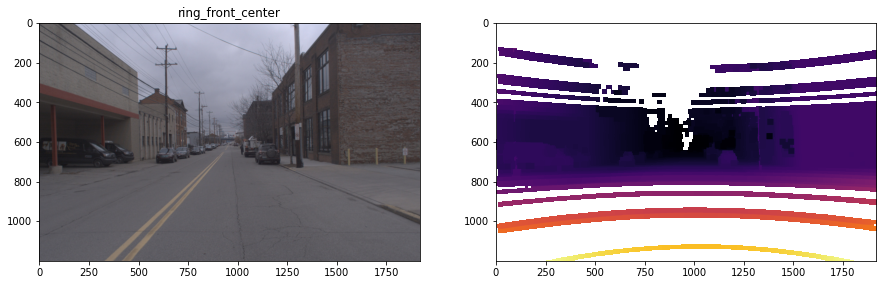

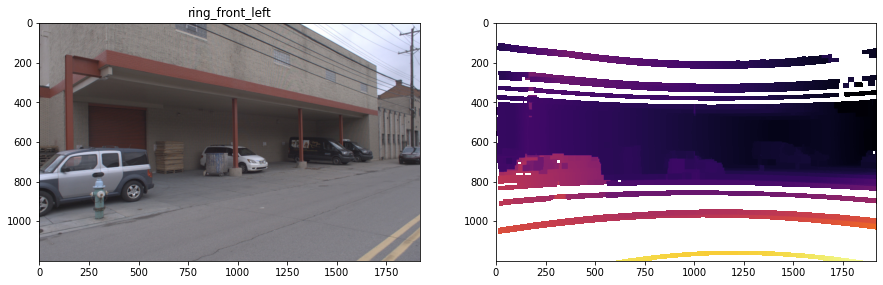

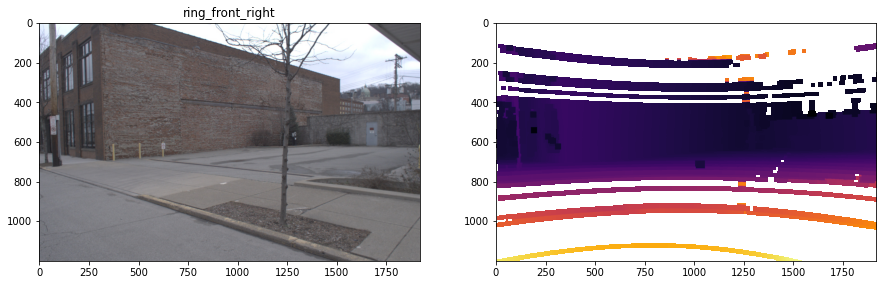

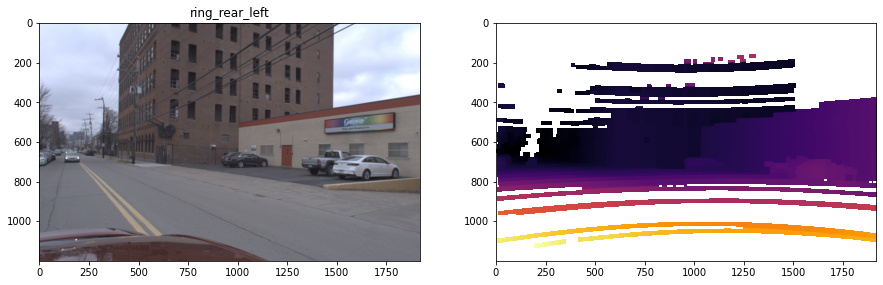

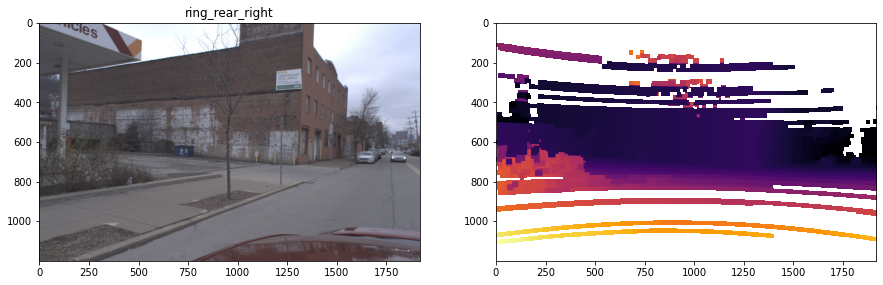

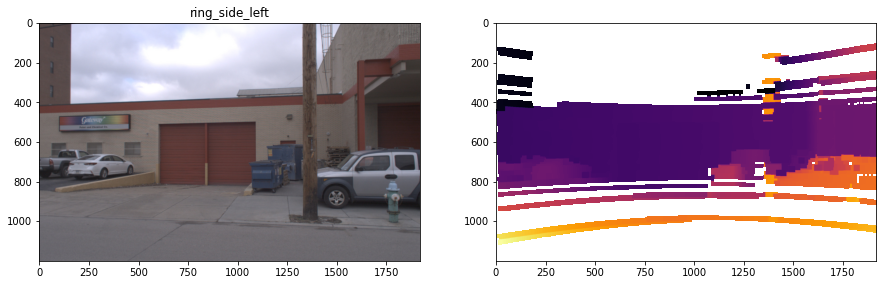

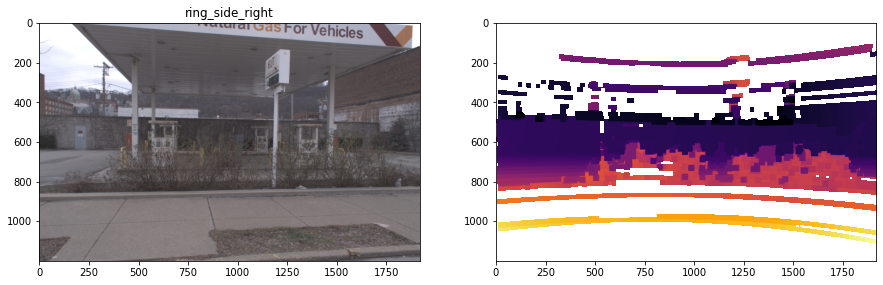

In [6]:
def display_depthmap(img_name: str, log_id: str, data_path: str) -> None:
    """
    For the provided image name, log_id and data_path (either train or val path)
    visualize depth map from all the ring cameras
    
    """
    for camera_ID in RING_CAMERA_LIST:
        # Load images
        rgb_image_path = os.path.join(data_path, "rgb", log_id, camera_ID, img_name)
        depth_image_path = os.path.join(data_path, "depth", log_id, camera_ID, img_name)
        rgb_image = cv2.cvtColor(
            cv2.imread(rgb_image_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB
        )
        depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED) / 256
        # Dilate for better visualization
        dilated_depth_image = cv2.dilate(
            depth_image, kernel=np.ones((2, 2), np.uint8), iterations=30
        )

        plt.figure(figsize=(15, 7))
        plt.subplot(121)
        plt.imshow(rgb_image)
        plt.title(camera_ID)
        plt.subplot(122)
        plt.imshow(1 / dilated_depth_image, cmap="inferno")
        plt.show()


img_name = "20.png"
log_id = "230970eb-dc2e-3133-b252-ff3c6f5d4284"
data_path = f"{output_save_path}/train/"
display_depthmap(img_name, log_id, data_path)

<div align="center">
<b> Now use the above data to train your monocular depth estimation model and show us what you can build using our data </b>
</div>